In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
from typing import Union, Literal

In [2]:
from utils_cnn import (
    convolution,
    pooling_one_point,
    init_kernel,
    init_bias_kernel,
    convolution_multiple_kernel,
    ReLU,
    init_weights,
    init_bias,
    softmax,
    one_hot,
    cross_entropy_loss,
    calculate_cross_entropy_loss_without_softmax_value,
    add_padding_multiple_point,
    add_dilation_multiple_point,
    decode_one_hot,
    Sigmoid,
    split_chunk_X_Y,
    convolution_multiple_kernel_multiple_point,
    pooling_multiple_point,
)

from derivative_cnn import (
    derivative_ReLU,
    derivative_for_filter_one_point,
    derivative_layer_before_max_pooling_for_multiple_point,
    derivative_for_filter_multiple_point,
    derivative_for_bias_kernel_multiple_point,
    derivative_layer_input_convolution_multiple_point,
    derivative_Sigmoid,
)

In [3]:
# Tải xuống dataset MNIST
(X, Y), (X_test, Y_test) = mnist.load_data()

# Kiểm tra kích thước của dữ liệu
print("Training data shape:", X.shape)  # (60000, 28, 28)
print("Testing data shape:", X_test.shape)    # (10000, 28, 28)

Training data shape: (60000, 28, 28)
Testing data shape: (10000, 28, 28)


In [4]:
len(X)

60000

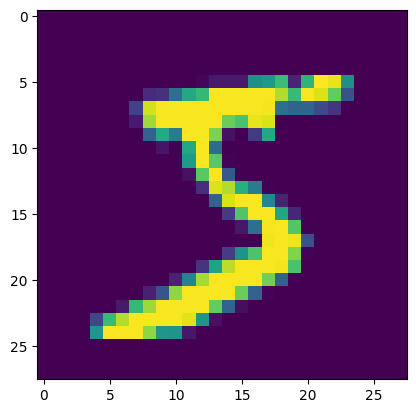

In [5]:
plt.imshow(X[0])

In [6]:
Y[0]

5

In [7]:
def reshape_list_X(list_X: Union[list[np.ndarray], np.ndarray]):
    N = len(list_X)
    list_P_0 = list_X
    
    if (type(list_X) == list and len(list_X[0].shape) == 3) or len(list_X.shape) == 4:
        pass
    elif type(list_X) == np.ndarray and len(list_X.shape) == 3:
        first_X = list_X[0]
        X_number_row = first_X.shape[0]
        X_number_col = first_X.shape[1]
        list_P_0 = list_X.reshape([N, X_number_row, X_number_col, 1])
    
    return list_P_0



In [8]:
def forward(
    mode: Literal["train", "predict"],

    list_P_0,
    
    K_11,
    K_12,
    bk_11,
    bk_12,
    sk_1,
    sp_1,
    size_pool_1,
    
    Zk_1_size,
    C_1_size,
    P_1_size,
    
    K_21,
    K_22,
    K_23,
    K_24,
    bk_21,
    bk_22,
    bk_23,
    bk_24,
    sk_2,
    sp_2,
    size_pool_2,

    Zk_2_size,
    C_2_size,
    P_2_size,
    
    W_1,
    b_1,
    
    W_2,
    b_2,
    
    W_3,
    b_3,
    
    Y=None):
        
        N = len(list_P_0)
        
        A_0 = np.zeros((np.prod(P_2_size), N))
            
        list_Zk_1 = convolution_multiple_kernel_multiple_point(list_P_0, (K_11, K_12), (bk_11, bk_12), sk_1)
        list_C_1 = ReLU(list_Zk_1)
        list_P_1 = pooling_multiple_point(list_C_1, size_pool_1, stride=sp_1)
        
        list_Zk_2 = convolution_multiple_kernel_multiple_point(list_P_1, (K_21, K_22, K_23, K_24), (bk_21, bk_22, bk_23, bk_24), sk_2)
        list_C_2 = Sigmoid(list_Zk_2)
        list_P_2 = pooling_multiple_point(list_C_2, size_pool_2, stride=sp_2)
        
        A_0 = list_P_2.flatten(order="C").reshape((np.prod(P_2_size), N), order="F")
        
        # Calculate for fully connected layers
        Z_1 = W_1.T.dot(A_0) + b_1
        A_1 = ReLU(Z_1)
        
        Z_2 = W_2.T.dot(A_1) + b_2
        A_2 = ReLU(Z_2)
        
        Z_3 = W_3.T.dot(A_2) + b_3
        A_3 = softmax(Z_3) # This is prediction output
        
        # calculate loss value by cross entropy
        loss = 0
        if mode == "train":
            loss = calculate_cross_entropy_loss_without_softmax_value(Y, Z_3)
        
        return {
            "list_Zk_1": list_Zk_1,
            "list_C_1": list_C_1,
            "list_P_1": list_P_1,
            
            "list_Zk_2": list_Zk_2,
            "list_C_2": list_C_2,
            "list_P_2": list_P_2,

            "A_0": A_0,
            
            "Z_1": Z_1,
            "A_1": A_1,
                    
            "Z_2": Z_2,
            "A_2": A_2,
            
            "Z_3": Z_3,
            "A_3": A_3,
            
            "loss": loss,
        }

In [9]:
def backpropagation(
    settings,
    
    list_P_0,
            
    K_11,
    K_12,
    bk_11,
    bk_12,
    sk_1,
    sp_1,
    size_pool_1,
    
    Zk_1_size,
    C_1_size,
    P_1_size,
    
    K_21,
    K_22,
    K_23,
    K_24,
    bk_21,
    bk_22,
    bk_23,
    bk_24,
    sk_2,
    sp_2,
    size_pool_2,
    
    Zk_2_size,
    C_2_size,
    P_2_size,
    
    W_1,
    b_1,
    
    W_2,
    b_2,
    
    W_3,
    b_3,
    
    Y
):
    """
    The derivative in this function can be proved in file: ./derivative_in_convolution 1.xlsx
    """
    for i in range(settings["epochs"]):
        output_forward = forward(
            "train",
            
            list_P_0,
            
            K_11,
            K_12,
            bk_11,
            bk_12,
            sk_1,
            sp_1,
            size_pool_1,
            
            Zk_1_size,
            C_1_size,
            P_1_size,
            
            K_21,
            K_22,
            K_23,
            K_24,
            bk_21,
            bk_22,
            bk_23,
            bk_24,
            sk_2,
            sp_2,
            size_pool_2,
            
            Zk_2_size,
            C_2_size,
            P_2_size,
            
            W_1,
            b_1,
            W_2,
            b_2,
            W_3,
            b_3,
            
            Y
        )
        
        
        list_Zk_1 = output_forward["list_Zk_1"] 
        list_C_1 = output_forward["list_C_1"] 
        list_P_1 = output_forward["list_P_1"] 
        
        list_Zk_2 = output_forward["list_Zk_2"] 
        list_C_2 = output_forward["list_C_2"] 
        list_P_2 = output_forward["list_P_2"] 
        
        A_0 = output_forward["A_0"] 
        
        Z_1 = output_forward["Z_1"] 
        A_1 = output_forward["A_1"] 
       
        Z_2 = output_forward["Z_2"] 
        A_2 = output_forward["A_2"] 
        
        Z_3 = output_forward["Z_3"] 
        A_3 = output_forward["A_3"] 
       
        loss = output_forward["loss"] 
        
        
        N = len(list_P_0)
        print(f"loop = {i}, loss = {loss}")
        
        # Backpropagation for fully connected layers
    
        E_3 = 1/N * (A_3 - Y)
        dL_dW_3 = A_2.dot(E_3.T)
        dL_db_3 = np.sum(E_3, axis=1, keepdims=True)
        
        E_2 = W_3.dot(E_3) * derivative_ReLU(Z_2)
        dL_dW_2 = A_1.dot(E_2.T)
        dL_db_2 = np.sum(E_2, axis=1, keepdims=True)
        
        E_1 = W_2.dot(E_2) * derivative_ReLU(Z_1)
        dL_dW_1 = A_0.dot(E_1.T)
        dL_db_1 = np.sum(E_1, axis=1, keepdims=True)
        
        # Backpropagation for kernel layers
        
        # Number of rows in dL_dP_2 = number of columns in dL_dA_0 = N
        # We loop through the columns of dL_dA_0 (respectively for each point data in X) and reshape it to size of P_2 and set that value in dL_dP_2
        dL_dA_0: np.ndarray = W_1.dot(E_1)
            
        list_dL_dP_2 = dL_dA_0.T.reshape([N] + P_2_size, order="C")

        list_dL_dC_2 = derivative_layer_before_max_pooling_for_multiple_point(list_C_2, list_P_2, list_dL_dP_2, size_pool_2, sp_2)
        list_dL_dZk_2 = list_dL_dC_2 * derivative_Sigmoid(list_Zk_2)
        
        dL_dK_21 = derivative_for_filter_multiple_point(list_P_1, list_dL_dZk_2[:, :, :, 0], K_21.shape, sk_2)
        dL_dK_22 = derivative_for_filter_multiple_point(list_P_1, list_dL_dZk_2[:, :, :, 1], K_22.shape, sk_2)
        dL_dK_23 = derivative_for_filter_multiple_point(list_P_1, list_dL_dZk_2[:, :, :, 2], K_23.shape, sk_2)
        dL_dK_24 = derivative_for_filter_multiple_point(list_P_1, list_dL_dZk_2[:, :, :, 3], K_24.shape, sk_2)
        
        dL_dbk_21 = derivative_for_bias_kernel_multiple_point(list_dL_dZk_2[:, :, :, 0])
        dL_dbk_22 = derivative_for_bias_kernel_multiple_point(list_dL_dZk_2[:, :, :, 1])
        dL_dbk_23 = derivative_for_bias_kernel_multiple_point(list_dL_dZk_2[:, :, :, 2])
        dL_dbk_24 = derivative_for_bias_kernel_multiple_point(list_dL_dZk_2[:, :, :, 3])
        
        list_dL_dP_1 = derivative_layer_input_convolution_multiple_point(list_P_1, [K_21, K_22, K_23, K_24], list_dL_dZk_2)
        list_dL_dC_1 = derivative_layer_before_max_pooling_for_multiple_point(list_C_1, list_P_1, list_dL_dP_1, size_pool_1, sp_1)
        list_dL_dZk_1 = list_dL_dC_1 * derivative_ReLU(list_Zk_1)
        
        dL_dK_11 = derivative_for_filter_multiple_point(list_P_0, list_dL_dZk_1[:, :, :, 0], K_11.shape, sk_1)
        dL_dK_12 = derivative_for_filter_multiple_point(list_P_0, list_dL_dZk_1[:, :, :, 1], K_12.shape, sk_1)
        
        dL_dbk_11 = derivative_for_bias_kernel_multiple_point(list_dL_dZk_1[:, :, :, 0])
        dL_dbk_12 = derivative_for_bias_kernel_multiple_point(list_dL_dZk_1[:, :, :, 1])
        
        W_3 = W_3 - settings["learning_rate"]*dL_dW_3
        b_3 = b_3 - settings["learning_rate"]*dL_db_3
        
        W_2 = W_2 - settings["learning_rate"]*dL_dW_2
        b_2 = b_2 - settings["learning_rate"]*dL_db_2
        
        W_1 = W_1 - settings["learning_rate"]*dL_dW_1
        b_1 = b_1 - settings["learning_rate"]*dL_db_1
        
        K_21 = K_21 - settings["learning_rate"]*dL_dK_21
        K_22 = K_22 - settings["learning_rate"]*dL_dK_22
        K_23 = K_23 - settings["learning_rate"]*dL_dK_23
        K_24 = K_24 - settings["learning_rate"]*dL_dK_24
        
        bk_21 = bk_21 - settings["learning_rate"]*dL_dbk_21
        bk_22 = bk_22 - settings["learning_rate"]*dL_dbk_22
        bk_23 = bk_23 - settings["learning_rate"]*dL_dbk_23
        bk_24 = bk_24 - settings["learning_rate"]*dL_dbk_24
        
        K_11 = K_11 - settings["learning_rate"]*dL_dK_11
        K_12 = K_12 - settings["learning_rate"]*dL_dK_12
        
        bk_11 = bk_11 - settings["learning_rate"]*dL_dbk_11
        bk_12 = bk_12 - settings["learning_rate"]*dL_dbk_12
    
    return {
        "K_11": K_11,
        "K_12": K_12,
        
        "bk_11": bk_11,
        "bk_12": bk_12,
        
        "K_21": K_21,
        "K_22": K_22,
        "K_23": K_23,
        "K_24": K_24,
        
        "bk_21": bk_21,
        "bk_22": bk_22,
        "bk_23": bk_23,
        "bk_24": bk_24,
        
        "W_1": W_1,
        "b_1": b_1,

        "W_2": W_2,
        "b_2": b_2,

        "W_3": W_3,
        "b_3": b_3,
    }

In [10]:
def forward_and_train_cnn(
    list_X: Union[list[np.ndarray], np.ndarray], 
    Y: np.ndarray, 
    learning_rate: float, 
    epochs: int,
    chunk_size: int = 300):
    """
    
    """
    
    list_P_0 = reshape_list_X(list_X)

    # Init value for convolution layers
    K_11 = init_kernel((5, 5, 1)) # Kernel 11 
    K_12 = init_kernel((5, 5, 1)) # Kernel 12
    bk_11 = init_bias_kernel() # Bias kernel 11
    bk_12 = init_bias_kernel() # Bias kernel 12
    sk_1 = 1 # Stride kernel 1
    sp_1 = 2 # Stride pool 1
    size_pool_1 = (2, 2) # Size of pooling 1
    
    K_21 = init_kernel((3, 3, 2)) # Kernel 21
    K_22 = init_kernel((3, 3, 2)) # Kernel 22
    K_23 = init_kernel((3, 3, 2)) # Kernel 23 
    K_24 = init_kernel((3, 3, 2)) # Kernel 24
    bk_21 = init_bias_kernel() # Bias kernel 21
    bk_22 = init_bias_kernel() # Bias kernel 22
    bk_23 = init_bias_kernel() # Bias kernel 23
    bk_24 = init_bias_kernel() # Bias kernel 24
    sk_2 = 1 # Stride kernel 2
    sp_2 = 2 # Stride pool 2
    size_pool_2 = (2, 2) # Size of pooling 1
    
    Zk_1_size = [24, 24, 2]
    C_1_size = [24, 24, 2]
    P_1_size = [12, 12, 2]
    
    Zk_2_size = [10, 10, 4]
    C_2_size = [10, 10, 4]
    P_2_size = [5, 5, 4]
    
    # Init value for fully connected layers
    number_nn_layer_1 = 100
    W_1 = init_weights((np.prod(P_2_size), number_nn_layer_1))
    b_1 = init_bias((number_nn_layer_1, 1))
    
    number_nn_layer_2 = 100
    W_2 = init_weights((number_nn_layer_1, number_nn_layer_2))
    b_2 = init_bias((number_nn_layer_2, 1))
    
    number_nn_layer_3 = Y.shape[0] # Number of categories into which the data is classified.
    W_3 = init_weights((number_nn_layer_2, number_nn_layer_3))
    b_3 = init_bias((number_nn_layer_3, 1))
    
    chunk_count = 0  
    for chunk_P_0, chunk_Y in split_chunk_X_Y(list_P_0, Y, chunk_size):
        print(f"Chunk {chunk_count}")
        chunk_count += 1
        
        # Backpropagation 
        params = backpropagation(
            {"epochs": epochs, "learning_rate": learning_rate},
            chunk_P_0,
            
            K_11,
            K_12,
            bk_11,
            bk_12,
            sk_1,
            sp_1,
            size_pool_1,
            
            Zk_1_size,
            C_1_size,
            P_1_size,
            
            K_21,
            K_22,
            K_23,
            K_24,
            bk_21,
            bk_22,
            bk_23,
            bk_24,
            sk_2,
            sp_2,
            size_pool_2,
            
            Zk_2_size,
            C_2_size,
            P_2_size,
            
            W_1,
            b_1,
            W_2,
            b_2,
            W_3,
            b_3,
            
            chunk_Y
        )
    
    

    return {
        "params": {
            "K_11": params["K_11"],
            "K_12": params["K_12"],
            
            "bk_11": params["bk_11"],
            "bk_12": params["bk_12"],
            
            "K_21": params["K_21"],
            "K_22": params["K_22"],
            "K_23": params["K_23"],
            "K_24": params["K_24"],
            
            "bk_21": params["bk_21"],
            "bk_22": params["bk_22"],
            "bk_23": params["bk_23"],
            "bk_24": params["bk_24"],
            
            "W_1": params["W_1"],
            "b_1": params["b_1"],

            "W_2": params["W_2"],
            "b_2": params["b_2"],

            "W_3": params["W_3"],
            "b_3": params["b_3"],
        },
        "config_size": {
            "sk_1": sk_1,
            "sp_1": sp_1,
            "size_pool_1": size_pool_1,
            
            "Zk_1_size": Zk_1_size,
            "C_1_size": C_1_size,
            "P_1_size": P_1_size,
            "sk_2": sk_2,
            "sp_2": sp_2,
            "size_pool_2": size_pool_2,
            
            "Zk_2_size": Zk_2_size,
            "C_2_size": C_2_size,
            "P_2_size": P_2_size,
        }
    }

In [11]:
number_train_points = 300

In [12]:
output = forward_and_train_cnn(
    X[0:number_train_points], 
    one_hot(Y[0:number_train_points]), 
    0.1, 
    500,
    5000)
params = output["params"]
config_size = output["config_size"]


    # X[number_train_points:number_train_points + 10]

Chunk 0
loop = 0, loss = 3.4032801867364446


d:\code\selenium\data_analytics\try_cnn\utils_cnn.py:596: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp((-1) * X))


loop = 1, loss = 3.2153454040831027
loop = 2, loss = 2.7531642575964783
loop = 3, loss = 2.4144444698037244
loop = 4, loss = 2.256024924474363
loop = 5, loss = 2.1652967185486522
loop = 6, loss = 2.1199329666835935
loop = 7, loss = 2.0768386210601437
loop = 8, loss = 2.0215682178111547
loop = 9, loss = 1.9861743960272937
loop = 10, loss = 1.9389528439916035
loop = 11, loss = 1.8883185033636445
loop = 12, loss = 1.8556711950651903
loop = 13, loss = 1.807694012690106
loop = 14, loss = 1.768547685173973
loop = 15, loss = 1.725239658013308
loop = 16, loss = 1.6814340782273087
loop = 17, loss = 1.6588043748866415
loop = 18, loss = 1.6048452638665898
loop = 19, loss = 1.5828424274884647
loop = 20, loss = 1.5764514143424952
loop = 21, loss = 1.6206283678472957
loop = 22, loss = 1.557079628810987
loop = 23, loss = 1.5879978077501085
loop = 24, loss = 1.532571494620799
loop = 25, loss = 1.4638178636830217
loop = 26, loss = 1.3907726245341243
loop = 27, loss = 1.3774375739997622
loop = 28, loss 

In [13]:
list_X_test = X_test[0:20]
output_forward = forward(
        "predict",
        
        reshape_list_X(list_X_test),
            
        params["K_11"],
        params["K_12"],
        params["bk_11"],
        params["bk_12"],
        config_size["sk_1"],
        config_size["sp_1"],
        config_size["size_pool_1"],
        
        config_size["Zk_1_size"],
        config_size["C_1_size"],
        config_size["P_1_size"],
        
        params["K_21"],
        params["K_22"],
        params["K_23"],
        params["K_24"],
        params["bk_21"],
        params["bk_22"],
        params["bk_23"],
        params["bk_24"],
        config_size["sk_2"],
        config_size["sp_2"],
        config_size["size_pool_2"],
        
        config_size["Zk_2_size"],
        config_size["C_2_size"],
        config_size["P_2_size"],
        
        params["W_1"],
        params["b_1"],
        params["W_2"],
        params["b_2"],
        params["W_3"],
        params["b_3"],
        
        None
    )

Y_predict = output_forward["A_3"]


In [14]:
Y_predict.shape

(10, 20)

In [15]:
Y_predict_decode = decode_one_hot(Y_predict, Y[0:number_train_points])
print(Y_predict_decode)
Y_real = Y_test[0:20]
print(Y_real)

[7 2 1 0 4 1 9 4 2 9 0 0 4 0 1 5 4 7 2 4]
[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]


In [16]:
result = Y_predict_decode == Y_real

In [17]:
len(result[result == True])

13

In [18]:
len(result[result == False])

7

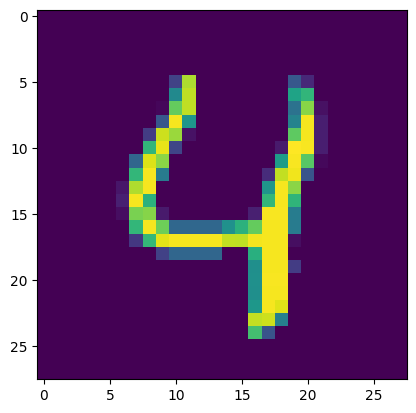

In [19]:
X_test_1 = list_X_test[4]
plt.imshow(X_test_1)


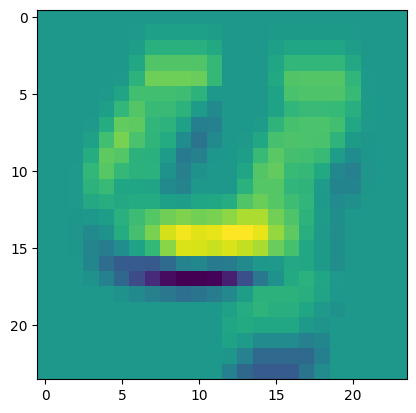

In [20]:
Zk_1_m1 = convolution(X_test_1, params["K_11"], bias=params["bk_11"])
plt.imshow(Zk_1_m1)

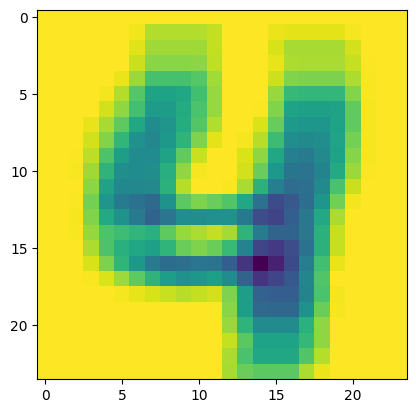

In [21]:
Zk_1_m2 = convolution(X_test_1, params["K_12"], bias=params["bk_12"])
plt.imshow(Zk_1_m2)

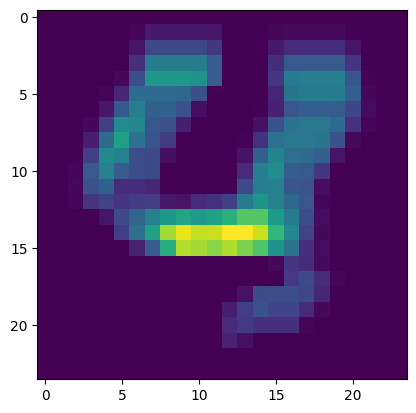

In [22]:
C_1_m1 = ReLU(Zk_1_m1)
plt.imshow(C_1_m1)

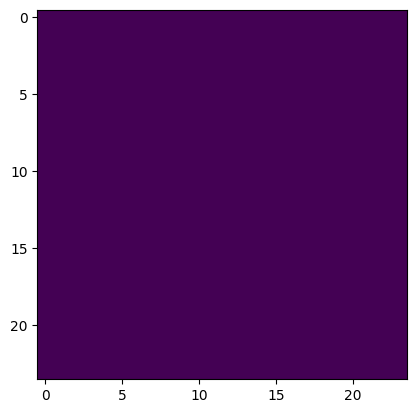

In [23]:
C_1_m2 = ReLU(Zk_1_m2)
plt.imshow(C_1_m2)

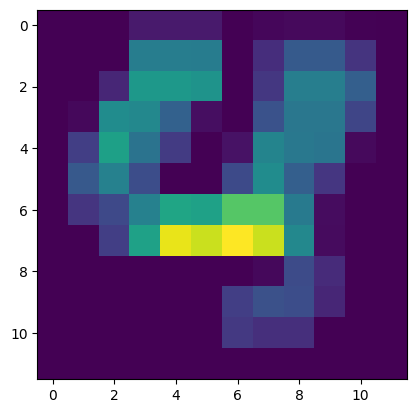

In [24]:
P_1_m1 = pooling_one_point(C_1_m1, (2, 2), stride=2)
plt.imshow(P_1_m1)

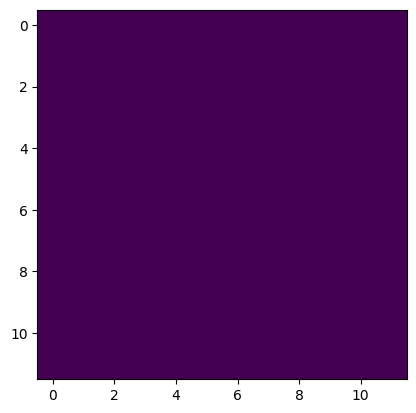

In [25]:
P_1_m2 = pooling_one_point(C_1_m2, (2, 2), stride=2)
plt.imshow(P_1_m2)

In [26]:
P_1 = np.zeros((12, 12, 2))
P_1[:,:,0] = P_1_m1
P_1[:,:,1] = P_1_m2

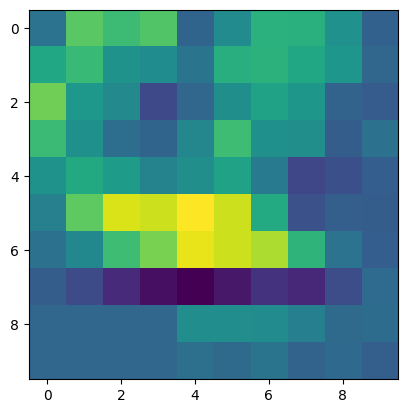

In [27]:
Zk_2_m1 = convolution(P_1, params["K_21"], bias=params["bk_21"])
plt.imshow(Zk_2_m1)

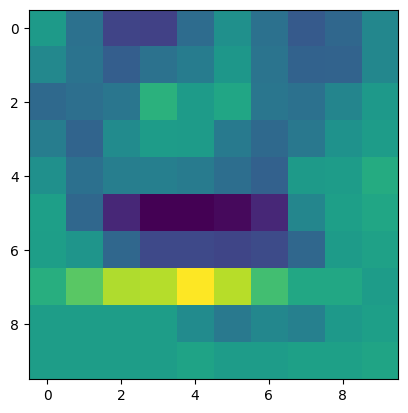

In [28]:
Zk_2_m2 = convolution(P_1, params["K_22"], bias=params["bk_22"])
plt.imshow(Zk_2_m2)

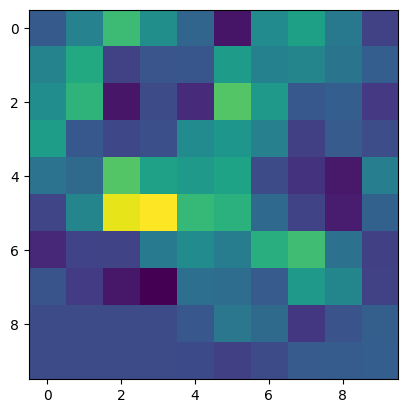

In [29]:
Zk_2_m3 = convolution(P_1, params["K_23"], bias=params["bk_23"])
plt.imshow(Zk_2_m3)

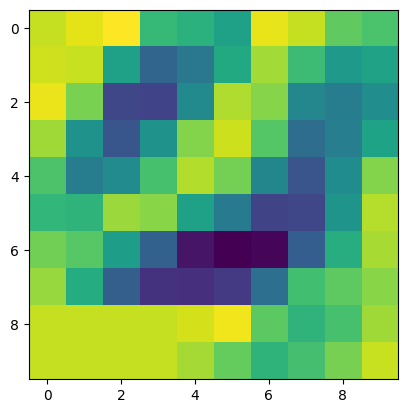

In [30]:
Zk_2_m4 = convolution(P_1, params["K_24"], bias=params["bk_24"])
plt.imshow(Zk_2_m4)

In [31]:
Zk_2 = np.zeros((10, 10, 4))
Zk_2[:,:,0] = Zk_2_m1
Zk_2[:,:,1] = Zk_2_m2
Zk_2[:,:,2] = Zk_2_m3
Zk_2[:,:,3] = Zk_2_m4

In [32]:
C_2 = Sigmoid(Zk_2)

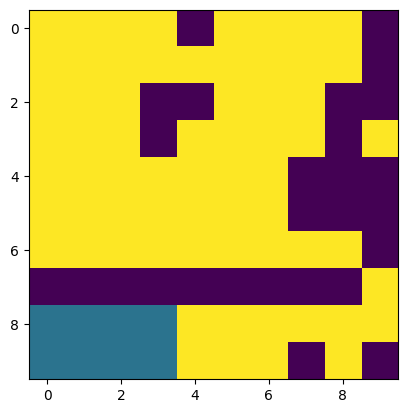

In [33]:
plt.imshow(C_2[:,:,0])


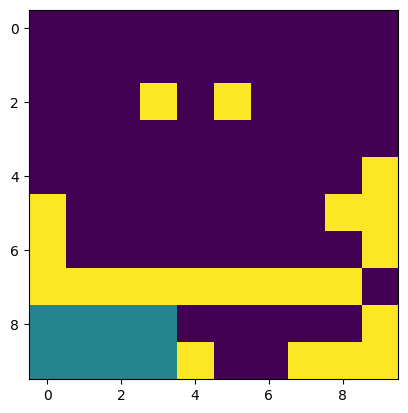

In [34]:
plt.imshow(C_2[:,:,1])


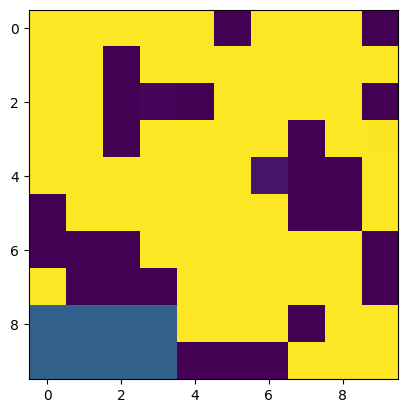

In [35]:
plt.imshow(C_2[:,:,2])


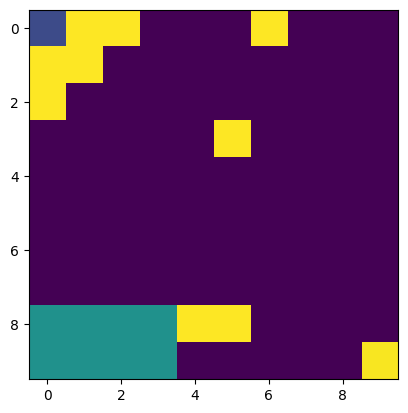

In [36]:
plt.imshow(C_2[:,:,3])

In [37]:
P_2 = pooling_one_point(C_2, (2, 2), stride=2)

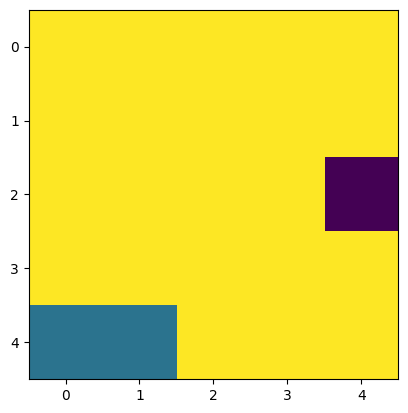

In [38]:
plt.imshow(P_2[:,:,0])


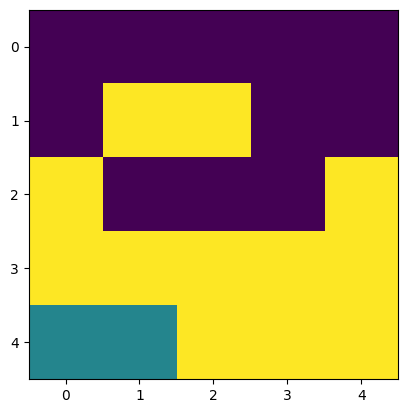

In [39]:
plt.imshow(P_2[:,:,1])


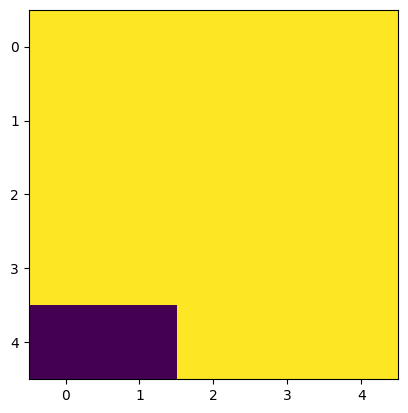

In [40]:
plt.imshow(P_2[:,:,2])


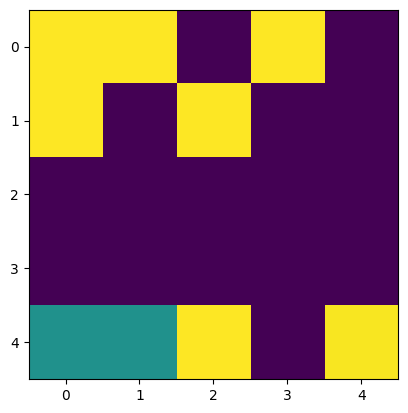

In [41]:
plt.imshow(P_2[:,:,3])